Using Euler time stepping

In [1]:
import numpy as np
from numpy import nanmedian
import pandas as pd
import os, glob
from pathlib import Path
import gsw
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import PyCO2SYS as pyco2
import xarray as xr
from datetime import datetime
from scipy.optimize import minimize
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import earthaccess as ea
import time
import copernicusmarine

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

## Location, Time

In [2]:
# directories
rawDir = "../data/raw/"
windDir = "../data/raw/wind/"
NPPDir = "../data/raw/NPP/"
SSTDir = "../data/raw/SST/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

In [3]:
# --- Simulation Settings ---
dt = 0.1  # years
total_time = 15  # years
nt = int(total_time / dt) # number of time steps
times = np.linspace(0, total_time, nt + 1)
print(times)

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15. ]


In [4]:
# use 365.2425 d/yr (or set to 365.0 to match your conventions)
DAYS_PER_YEAR = 365.2425
SECONDS_PER_YEAR = DAYS_PER_YEAR * 86400.0

# choose the simulation start date in UTC
sim_start = pd.Timestamp("2010-01-01T00:00:00Z")
sim_end = sim_start + pd.to_timedelta(total_time * DAYS_PER_YEAR, unit="D")

start_time = sim_start.strftime("%Y-%m-%dT%H:%M:%SZ")
end_time   = (sim_end - pd.Timedelta(seconds=1)).strftime("%Y-%m-%dT%H:%M:%SZ")  # inclusive end

# Simulation time array in datetime format
print("Simulation start:", start_time, " end:", end_time)


Simulation start: 2010-01-01T00:00:00Z  end: 2024-12-31T15:17:58Z


In [5]:
# --- Interpolate monthly series to model step centers ---
edges   = sim_start + pd.to_timedelta(times * DAYS_PER_YEAR, unit="D")
centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2
centers = pd.DatetimeIndex(centers).tz_localize(None)  # ensure tz-naive to match CCMP time

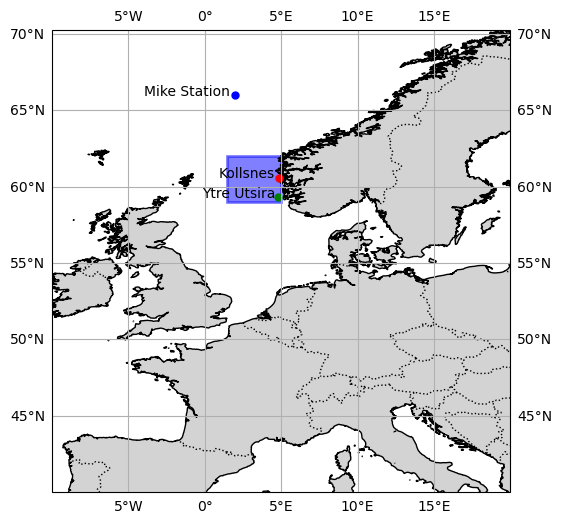

In [6]:
# --- Physical Constants ---
lat_min = 59.015176
lat_max = 61.984824
lon_min = 1.431594
lon_max = 5.000000

# Coordinates for Kollsnes
# (approximate)
kollsnes_lat, kollsnes_lon = 60.55310, 4.88361

# Data location
data_lat, data_lon = 59.3167, 4.8000 # approx center of region
mike_lat, mike_lon = 66, 2
# --- Create a map ---
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-10, 20, 40, 70])  # wider map view around area


# --- Add rectangle for your lat/lon range ---
rect = Rectangle(
    (lon_min, lat_min),             # lower-left corner
    lon_max - lon_min,              # width (in degrees)
    lat_max - lat_min,              # height (in degrees)
    linewidth=2,
    edgecolor='blue',
    facecolor='blue',
    alpha=0.5,  # semi-transparent
    transform=ccrs.PlateCarree()
)

# --- Add port as dot and label ---
ax.plot(kollsnes_lon, kollsnes_lat, 'ro', markersize=5, transform=ccrs.PlateCarree(), label='Kollsnes Port')
ax.text(kollsnes_lon - 4, kollsnes_lat + 0.1, 'Kollsnes', transform=ccrs.PlateCarree())
# Add data as dot and label to the left of the dot
ax.plot(data_lon, data_lat, 'go', markersize=5, transform=ccrs.PlateCarree(), label='Ytre Utsira')
ax.text(data_lon - 5, data_lat, 'Ytre Utsira', transform=ccrs.PlateCarree())

ax.plot(mike_lon, mike_lat, 'bo', markersize=5, transform=ccrs.PlateCarree(), label='Mike Station')
ax.text(mike_lon - 6, mike_lat, 'Mike Station', transform=ccrs.PlateCarree())

ax.add_patch(rect)
ax.gridlines(draw_labels=True)
plt.savefig(imgDir + "map_region.png", dpi=300)
plt.show()


## Bathymetry and Mixed layer depth -> h1, h2

In [7]:
mld_nc = Path(rawDir) / "cmems_nws_phy_mld.nc"

# Download once
if not mld_nc.exists():
    copernicusmarine.subset(
        dataset_id="cmems_mod_nws_phy-mld_my_7km-2D_P1M-m",  # NWS monthly MLD (MY)
        variables=["mlotst"],                                 # mixed layer depth (m)
        minimum_longitude=lon_min, maximum_longitude=lon_max,
        minimum_latitude=lat_min,  maximum_latitude=lat_max,
        start_datetime=start_time, end_datetime=end_time,
        output_filename=mld_nc.name,
        output_directory=str(mld_nc.parent)
    )

# Open
mld_ds = xr.open_dataset(mld_nc)

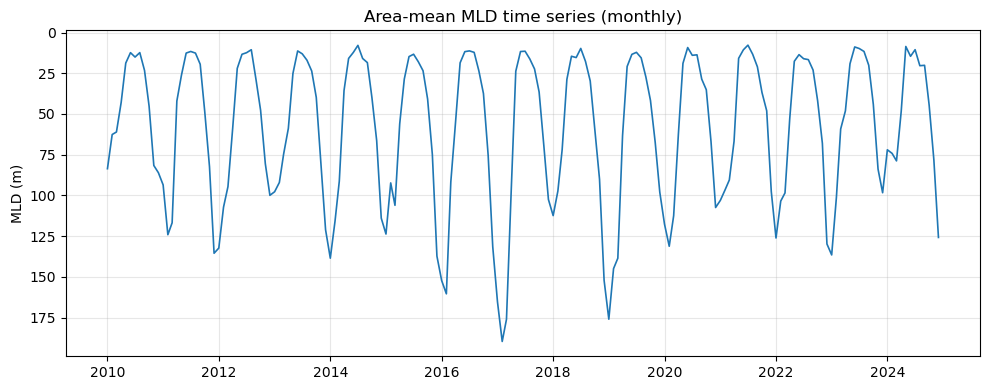

In [8]:
# 2) Area-average over the region
mld_area = mld_ds["mlotst"].mean(dim=["latitude", "longitude"], skipna=True)

# 3) Make sure time is timezone-naive pandas-friendly
mld_area = mld_area.assign_coords(
    time = pd.DatetimeIndex(mld_area["time"].values).tz_localize(None)
)

plt.figure(figsize=(10,4))
plt.plot(
    pd.to_datetime(mld_area["time"].values),
    mld_area.values,
    lw=1.2,
)
plt.gca().invert_yaxis()  # optional
plt.grid(alpha=0.3)
plt.ylabel("MLD (m)")
plt.title("Area-mean MLD time series (monthly)")
plt.tight_layout()
plt.savefig(imgDir + "MLD_monthly.png", dpi=300)
plt.show()


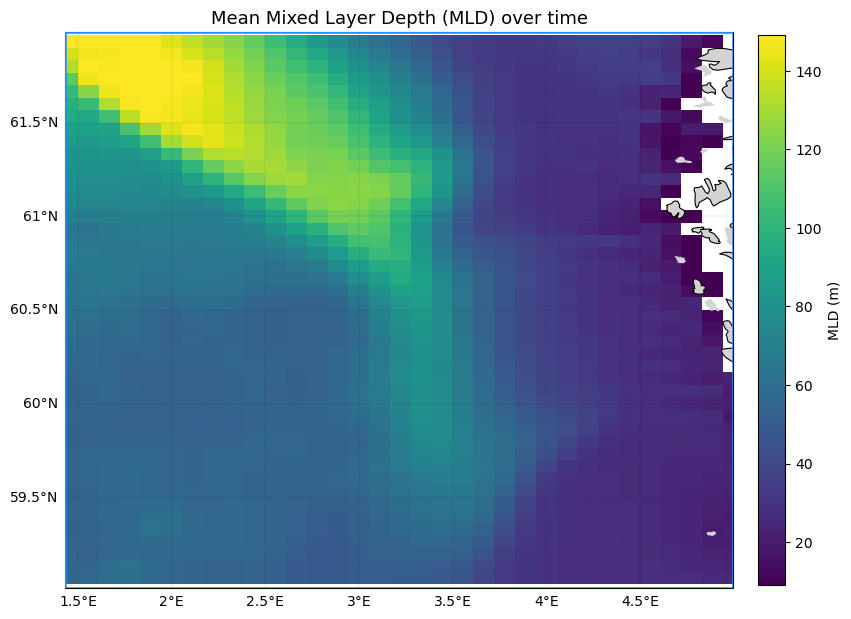

In [9]:
# ---- time-mean MLD per grid cell ----
# (averages across full time horizon in your file)
mld_mean_map = mld_ds["mlotst"].mean(dim='time', skipna=True)

# ---- plot map of time-mean MLD ----
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection=proj)
ax.set_title("Mean Mixed Layer Depth (MLD) over time", fontsize=13)

# background layers
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':', zorder=2)

# choose colormap scaling (robust percentiles)
vmin = float(mld_mean_map.quantile(0.01))
vmax = float(mld_mean_map.quantile(0.99))

# pcolormesh works with regular or curvilinear lon/lat
if ('latitude' in mld_mean_map.coords) and ('longitude' in mld_mean_map.coords):
    pm = ax.pcolormesh(
        mld_mean_map['longitude'], mld_mean_map['latitude'], mld_mean_map,
        transform=proj, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax, zorder=0
    )
    # set extent from your requested box
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
else:
    # If lon/lat are not provided as 1D/2D coord variables, just plot in data coords
    pm = plt.pcolormesh(mld_mean_map, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)

# add your selection rectangle
rect = Rectangle(
    (lon_min, lat_min),
    lon_max - lon_min, lat_max - lat_min,
    linewidth=1.8, edgecolor='dodgerblue', facecolor='none', zorder=3, transform=proj
)
ax.add_patch(rect)

# colorbar
cb = plt.colorbar(pm, ax=ax, shrink=0.82, pad=0.03)
cb.set_label("MLD (m)")

# gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='k', alpha=0.25, linestyle='--')
gl.right_labels = False
gl.top_labels = False

plt.tight_layout()
plt.savefig(imgDir + "MLD_map.png", dpi=300)
plt.show()


In [10]:
bathy_nc = Path(rawDir) / "cmems_nws_phy_bathy.nc"

# Download once
if not bathy_nc.exists():
    copernicusmarine.subset(
        dataset_id="cmems_mod_nws_phy_my_7km-3D_static",
        dataset_part="bathy",
        variables=["deptho", "deptho_lev_interp"],
        minimum_longitude=lon_min, maximum_longitude=lon_max,
        minimum_latitude=lat_min,  maximum_latitude=lat_max,
        minimum_depth=0,
        maximum_depth=0,
        output_filename=bathy_nc.name,
        output_directory=str(bathy_nc.parent)
    )

# Open
bathy_ds = xr.open_dataset(bathy_nc)

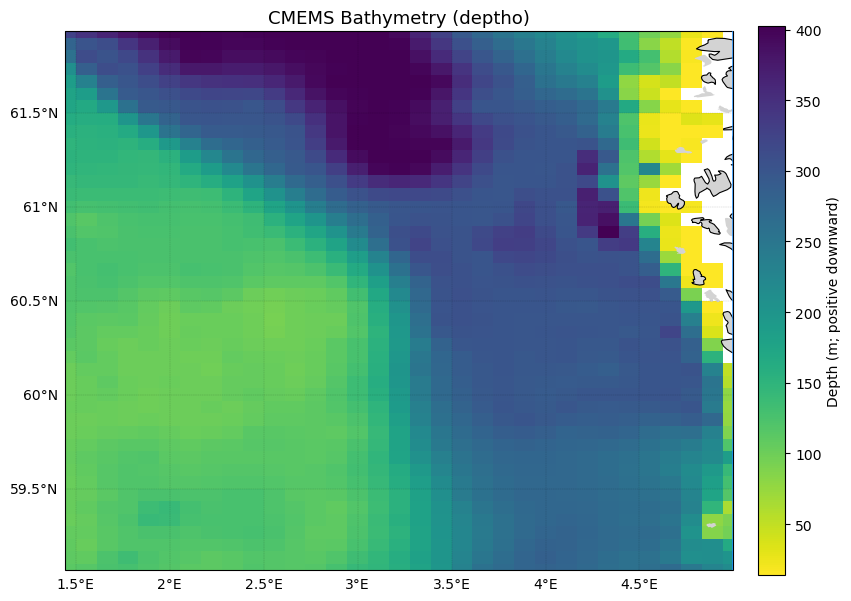

In [11]:
# mask land/zero depths so color scale focuses on ocean
depth = bathy_ds["deptho"].where(bathy_ds["deptho"] > 0)

# optional: set a nice top/bottom for the color scale (e.g., 1st–99th percentile)
vmin = float(depth.quantile(0.01))
vmax = float(depth.quantile(0.99))

# --- plot ---
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection=proj)

# background
ax.set_title("CMEMS Bathymetry (deptho)", fontsize=13)
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":", zorder=2)

# set a reasonable extent (or use your earlier one)
try:
    ax.set_extent([
        float(depth['longitude'].min()), float(depth['longitude'].max()),
        float(depth['latitude'].min()), float(depth['latitude'].max())
    ], crs=proj)
except Exception:
    pass  # for curvilinear grids, set extent manually if desired

# pcolormesh (works with both regular & curvilinear grids)
pm = ax.pcolormesh(
    depth['longitude'], depth['latitude'], depth,
    transform=proj, cmap="viridis_r", shading="auto",
    vmin=vmin, vmax=vmax, zorder=0
)

# colorbar
cb = plt.colorbar(pm, ax=ax, shrink=0.82, pad=0.03)
cb.set_label("Depth (m; positive downward)")

# optional: add your selection rectangle (use your lon/lat bounds)
rect = Rectangle(
    (lon_min, lat_min),
    lon_max - lon_min,
    lat_max - lat_min,
    linewidth=1.8, edgecolor="dodgerblue", facecolor="none", zorder=3,
    transform=proj
)
ax.add_patch(rect)

# gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="k", alpha=0.25, linestyle="--")
gl.right_labels = False
gl.top_labels = False

plt.tight_layout()
plt.savefig(imgDir + "Bathymetry_map.png", dpi=300)
plt.show()


### Option A - h1, h2 static parameters

In [12]:
# --- Robust H from bathymetry (ignore land/zeros; clip deep outliers) ---
H_median = float(depth.median(skipna=True))


# Static choice (Option A):
h1_static = float(mld_area.median(skipna=True))
h2_static = H_median - h1_static         
print(f"Static h1={h1_static:.1f} m, h2={h2_static:.1f} m (H≈{H_median:.1f} m)")

Static h1=44.9 m, h2=179.9 m (H≈224.7 m)


### Option B - h1, h2 as time series

In [13]:
# Variable choice (Option B):
h1_for_step = mld_area.interp(time=centers).to_numpy()  # m
h2_for_step = H_median - h1_for_step

delta_z_for_step = 0.5*h1_for_step + 0.5*h2_for_step

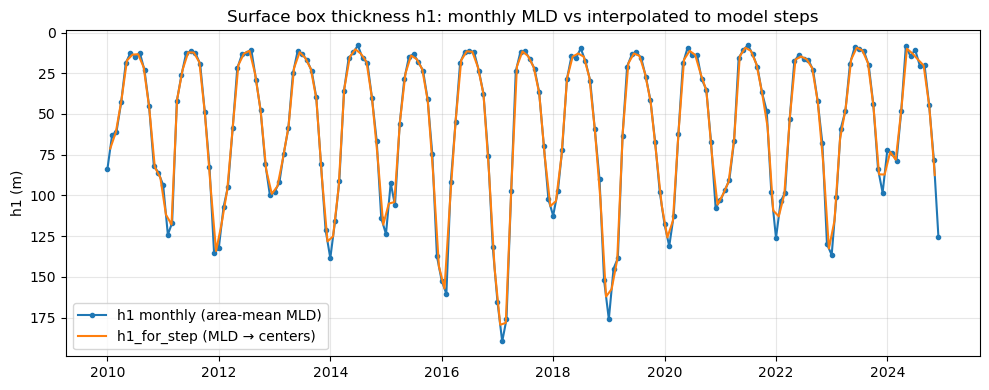

In [14]:
plt.figure(figsize=(10,4))

# native monthly MLD as h1 (area-mean)
plt.plot(
    pd.to_datetime(mld_area["time"].values),
    mld_area.values,
    label="h1 monthly (area-mean MLD)",
    lw=1.5,
    marker="o",
    ms=3,
)

# interpolated to model step centers
plt.plot(
    centers,
    h1_for_step,
    label="h1_for_step (MLD → centers)",
    lw=1.5,
)

plt.gca().invert_yaxis()  # deeper MLD = larger number, so flip if you like that visual
plt.grid(alpha=0.3)
plt.ylabel("h1 (m)")
plt.title("Surface box thickness h1: monthly MLD vs interpolated to model steps")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "h1_monthly_step.png", dpi=300)
plt.show()


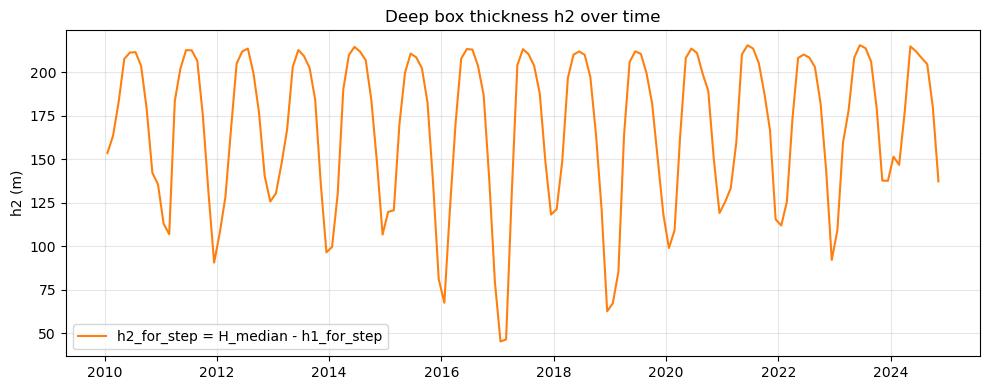

In [15]:
plt.figure(figsize=(10,4))

plt.plot(
    centers,
    h2_for_step,
    lw=1.5,
    color="tab:orange",
    label="h2_for_step = H_median - h1_for_step"
)

plt.grid(alpha=0.3)
plt.ylabel("h2 (m)")
plt.title("Deep box thickness h2 over time")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "h2_step.png", dpi=300)
plt.show()


## PICtoPOC

In [16]:
# --- load csv ---
df = pd.read_csv(rawDir + "Compilation_Bloom_Area_Terrats_Thershold_NL0723.csv")

box = df['lat'].between(lat_min, lat_max) & df['lon'].between(lon_min, lon_max)
print(df.loc[box, ['lat', 'lon', 'MLD', 'PICtoPOC']])
PICPOC = df.loc[box, 'PICtoPOC'].mean()
print("PIC:POC — mean:", PICPOC)

# PictoPOC ratio mean for entire file
picpoc_mean = df['PICtoPOC'].mean()
print("Overall PIC:POC mean:", picpoc_mean)


       lat  lon  MLD  PICtoPOC
1178  60.5  2.5  NaN  0.058947
1179  60.5  4.5  NaN  0.019093
1217  61.5  1.5  NaN  0.057254
1218  61.5  2.5  NaN  0.043736
1219  61.5  3.5  NaN  0.045948
1220  61.5  4.5  NaN  0.024040
PIC:POC — mean: 0.04150301927228127
Overall PIC:POC mean: 0.08380933471178018


## Parameter

In [17]:
params = {
    'T1_star': 8.9, # °C
    'T2_star': 8.3, # °C
    'S1_star': 35.1, # psu
    'S2_star': 35.1, # psu
    'A_1T': 3.50, # °C
    'A_1S': -0.3, # psu
    'A_2T': 2.5, # °C
    'phi_1T': -0.97, # radians
    'phi_1S': -0.45, # radians
    'phi_2T': -1.54, # radians
    'tau_1T': 0.09, # yr
    'tau_1S': 0.27, # yr
    'tau_2': 0.15, # yr
    'KD': 1.5e-5, # m^2/s
    'PICPOC': PICPOC, # dimensionless rain ratio         
    'f_remin_POC': 0.99,     # frac of POC export remin in box 2
    'f_diss_PIC': 0.3,      # frac of PIC export dissolved in box 2
    'TPOC': 1.0,             # fraction of exported POC that reaches sediment
    'TPIC': 1.0,             # fraction of exported PIC that reaches sediment
    'Remin': 1.0, # unitless
    'h1': h1_static, # m
    'h2': h2_static  # m
}

#'KD' m^2/s -> m^2/yr
KD_m2_yr = params['KD'] * SECONDS_PER_YEAR  # m^2/yr

# pCO2_atm is the atmospheric partial pressure of CO2
pCO2_atm = 420  # in µatm

delta_z = (params["h1"] + params["h2"])/2

In [19]:
# --- Initial Conditions ---
initial_state = np.array([
    8,  # T1 °C
    8,   # T2 °C
    35.1,  # S1 psu
    35.1,  # S2 psu
    1890.1, # DIC1 µmol/kg
    2019.0, # DIC2 µmol/kg
    2160.6, # TA1 µmol/kg
    2125.7  # TA2 µmol/kg
])

## Helper Functions

In [20]:
# Choose a single representative point for the box (fine for a 2-box model)
lon0 = (lon_min + lon_max) / 2.0  # ~10.0E for your box
lat0 = (lat_min + lat_max) / 2.0  # ~57.5N

# --- Function to compute potential density anomaly σ0 using TEOS-10 ---
def sigma0_from_TS(SP_psu, T_C, p_dbar, lon=lon0, lat=lat0):
    """
    Return potential density anomaly σ0 [kg m^-3 - 1000] using TEOS-10,
    given Practical Salinity (SP), in-situ T, and local sea pressure p (dbar).
    """
    SA = gsw.SA_from_SP(SP_psu, p_dbar, lon, lat)      # Absolute Salinity [g/kg]
    CT = gsw.CT_from_t(SA, T_C, p_dbar)                # Conservative Temp [°C]
    return gsw.sigma0(SA, CT) 

In [21]:
# -----------------------
# Air–sea CO2 gas-transfer 
# -----------------------
def schmidt_number_CO2_W14(temp_C):
    # Jähne et al. (1987) as listed in Wanninkhof (2014); dimensionless
    T = temp_C
    a, b, c, d, e = 2116.8, -136.25, 4.7353, -0.092307, 0.0007555
    return a + b*T + c*T**2 + d*T**3 + e*T**4

def k_W14_from_U2(U2, temp_C):
    """
    U2: <U^2> (m^2 s^-2) for the averaging window
    temp_C: temperature (°C) for Schmidt correction (scalar or array matching U2)
    Returns: k (in-situ) in cm hr^-1
    """
    Sc = schmidt_number_CO2_W14(temp_C)
    k = 0.251 * U2 * np.sqrt(660.0 / Sc)  # cm/hr
    return k

def K0_weiss74_CO2(temp_C, sal):
    """Weiss (1974) CO2 solubility: returns K0 in mol kg^-1 atm^-1."""
    T = temp_C + 273.15  # K
    A1, A2, A3 = -58.0931, 90.5069, 22.2940
    B1, B2, B3 = 0.027766, -0.025888, 0.0050578
    lnK0 = A1 + A2 * (100.0 / T) + A3 * np.log(T / 100.0) \
           + sal * (B1 + B2 * (T / 100.0) + B3 * (T / 100.0) ** 2)
    return np.exp(lnK0)  # mol kg^-1 atm^-1

In [22]:
def subset_box_0360(ds, lon_name="longitude", lat_name="latitude"):
    """Subset a 0–360° longitude grid to the desired box, 
    handling wrap-around across 0° if needed."""
    L0 = (np.asarray(lon_min) % 360 + 360) % 360
    L1 = (np.asarray(lon_max) % 360 + 360) % 360

    if L0 <= L1:
        return ds.sel({lon_name: slice(L0, L1), lat_name: slice(lat_min, lat_max)})
    else:
        # Box crosses 0° meridian: stitch two slices
        left  = ds.sel({lon_name: slice(L0, 360), lat_name: slice(lat_min, lat_max)})
        right = ds.sel({lon_name: slice(0,  L1), lat_name: slice(lat_min, lat_max)})
        return xr.concat([left, right], dim=lon_name)

## Wind

In [23]:
U2_file = Path("../data/interim/") / "U2_for_step.npy"

# -------------------------------------------------
# Check if U2_for_step already exists
# -------------------------------------------------
if U2_file.exists():
    print(f"Loading precomputed U2_for_step from {U2_file}")
    U2_for_step = np.load(U2_file)
    print(f"Loaded {len(U2_for_step)} steps from cached file.")
else:
    print("No cached U2_for_step found → downloading and computing …")

    # concept id for monthly
    CCMP_monthly_CONCEPT_ID = "C2916529935-POCLOUD"

    nc_files = sorted([p for p in Path(windDir).glob("*.nc*")])

    if not nc_files:
        print("No local CCMP monthly files found -> logging in and downloading …")
        ea.login()
        granules = ea.search_data(
            concept_id=CCMP_monthly_CONCEPT_ID,
            temporal=(start_time, None),
        )
        files = ea.download(granules, local_path=windDir)  # save to your windDir
        time.sleep(1.5)
        nc_files = sorted([Path(f) for f in files if Path(f).suffix.startswith(".nc")])
    else:
        print(f"Found {len(nc_files)} CCMP monthly file(s). Skipping download.")

    if not nc_files:
        raise FileNotFoundError("No CCMP .nc monthly files available in windDir after check/download.")

    # -----------------------
    # Open CCMP monthly chunks
    # -----------------------
    # chunks: time by 8 timesteps (~2 days), full lat/lon per chunk
    ds = xr.open_mfdataset(
        nc_files,
        combine="by_coords",
        chunks={"time": 8, "latitude": -1, "longitude": -1},
    )

    ds_box = subset_box_0360(ds, lon_name="longitude", lat_name="latitude")
    print(ds_box.sizes)
    print(float(ds_box.latitude.min()), "→", float(ds_box.latitude.max()))
    print(float(ds_box.longitude.min()), "→", float(ds_box.longitude.max()))

    # -----------------------
    # Native U^2 at 6-hourly resolution (m^2 s^-2)
    # -----------------------
    U2_monthly = (ds_box["w"] ** 2).rename("U2")
    U2_monthly.attrs.update(units="m2 s-2", long_name="10 m wind second moment (monthly)")

    # --- Area-weighted mean over your box ---
    lat = U2_monthly["latitude"]
    weights_lat = np.cos(np.deg2rad(lat))
    weights_lat = weights_lat / weights_lat.mean()  # optional normalization
    U2_monthly_wmean = (U2_monthly * weights_lat).mean(dim=("latitude", "longitude"))  # time series (monthly)

    # U2 at model step centers (linear in time)
    U2_step = U2_monthly_wmean.interp(time=centers)
    U2_step = U2_step.assign_coords(time=("time", centers))
    U2_step.attrs.update(units="m2 s-2",
                         long_name="area-weighted U^2 (CCMP monthly → interp to model centers)")

    # materialize to a small numpy array
    U2_for_step = U2_step.to_numpy()
    assert len(U2_for_step) == len(times) - 1, (len(U2_for_step), len(times)-1)

    # cache for reuse
    np.save(U2_file, U2_for_step)
    print(f"Saved U2_for_step ({len(U2_for_step)} values) to {U2_file}")

Loading precomputed U2_for_step from ..\data\interim\U2_for_step.npy
Loaded 150 steps from cached file.


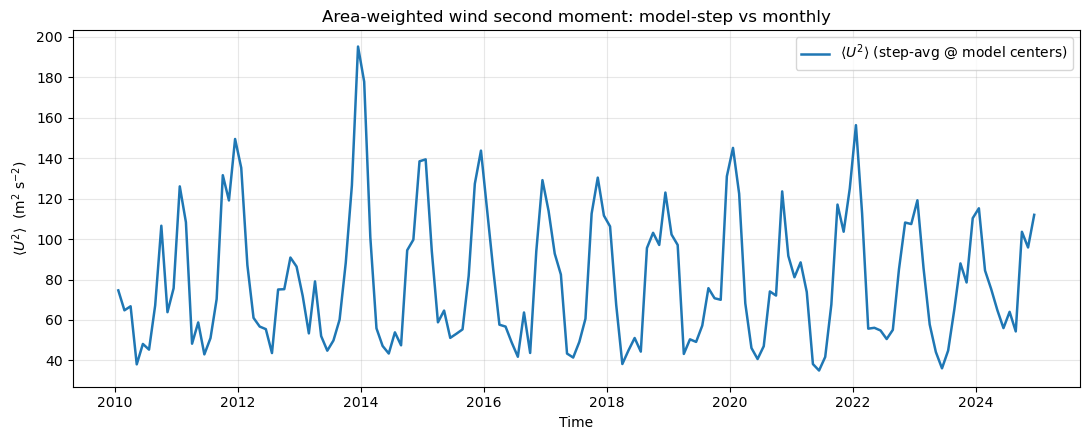

In [24]:
# --- Plot ⟨U²⟩ over time: model-step vs monthly weighted mean ---
plt.figure(figsize=(11, 4.5))

# 1) Model-step centers (already interpolated to centers)
plt.plot(
    centers,
    U2_for_step,
    label=r"$\langle U^2 \rangle$ (step-avg @ model centers)",
    lw=1.8,
)

# 2) Native monthly weighted-mean time series
#t_monthly = pd.to_datetime(U2_monthly_wmean["time"].values)
#plt.plot(
#    t_monthly,
#    U2_monthly_wmean.values,
#    linestyle="--",
#    lw=1.6,
#    label=r"$\langle U^2 \rangle$ (monthly w-mean)",
#)

plt.title("Area-weighted wind second moment: model-step vs monthly")
plt.xlabel("Time")
plt.ylabel(r"$\langle U^2 \rangle$  (m$^2$ s$^{-2}$)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "U2_step.png", dpi=300)
plt.show()


## Net primary production

### Option A - static h1,h2

In [25]:
NPP_file = Path("../data/interim/") / "NPP_for_step.npy"
npp_nc   = Path(NPPDir) / "cmems_nwshelf_npp_2000_2024.nc" 

# -------------------------------------------------
# Check cache first
# -------------------------------------------------
if NPP_file.exists():
    print(f"Loading cached NPP_for_step from {NPP_file}")
    NPP_for_step = np.load(NPP_file)
    print(f"Loaded {len(NPP_for_step)} steps.")
else:
    print("No cached NPP_for_step found → preparing NPP …")

    # -------------------------------------------------
    # Ensure we have the raw CMEMS subset NetCDF
    # -------------------------------------------------
    if not npp_nc.exists():
        print(f"No local NPP NetCDF → downloading subset to {npp_nc}")
        copernicusmarine.subset(
            dataset_id="cmems_mod_nws_bgc-pp_my_7km-3D_P1M-m",
            variables=["nppv"],
            minimum_longitude=lon_min,
            maximum_longitude=lon_max,
            minimum_latitude=lat_min,
            maximum_latitude=lat_max,
            start_datetime=start_time,
            end_datetime=end_time,
            output_filename = "cmems_nwshelf_npp_2000_2024.nc",
            output_directory = NPPDir
        )
    else:
        print(f"Found local NPP NetCDF: {npp_nc}")

    # -------------------------------------------------
    # Open and process to monthly 
    # -------------------------------------------------
    ds_npp = xr.open_dataset(NPPDir + "cmems_nwshelf_npp_2000_2024.nc")
    
    # 1) subset the vertical range (0..h1); dataset uses 'depth' increasing downward
    npp_0_h1 = ds_npp["nppv"].sel(depth=slice(0, params['h1']))

    # 2) Build layer thickness (dz) from depth midpoints
    z = npp_0_h1["depth"].values
    zedges = np.zeros(z.size + 1)
    zedges[1:-1] = 0.5 * (z[1:] + z[:-1])
    zedges[0] = z[0] - (zedges[1] - z[0])
    zedges[-1] = z[-1] + (z[-1] - zedges[-2])
    zedges = np.clip(zedges, 0, params['h1'])
    dz = np.maximum(np.diff(zedges), 0)
    dz = xr.DataArray(dz, dims=["depth"], coords={"depth": npp_0_h1["depth"]})

    # 3) Integrate over depth (mg/m3/day * m = mg/m2/day)
    npp_int = (npp_0_h1 * dz).sum(dim="depth", skipna=True)

    # 4) spatial average over latitude & longitude ---
    npp_mean = npp_int.mean(dim=["latitude", "longitude"], skipna=True)

    # make NPP time tz-naive to match centers
    npp_mean = npp_mean.assign_coords(
        time=pd.DatetimeIndex(npp_mean["time"].values).tz_localize(None)
    )

    # 5) interpolate monthly NPP to model step centers
    NPP_step = npp_mean.interp(time=centers)

    # 6) materialize and cache
    NPP_for_step = NPP_step.to_numpy()
    assert len(NPP_for_step) == len(times) - 1, (len(NPP_for_step), len(times)-1)

    np.save(NPP_file, NPP_for_step) # mg m^-2 d^-1
    print(f"Saved NPP_for_step ({len(NPP_for_step)} values) to {NPP_file}")


Loading cached NPP_for_step from ..\data\interim\NPP_for_step.npy
Loaded 150 steps.


### Option B - variable h1, h2

In [26]:
NPP_file_mld = Path("../data/interim/") / "NPP_for_step_mld.npy"

if NPP_file_mld.exists():
    print(f"Loading cached NPP_for_step from {NPP_file_mld}")
    NPP_for_step_mld = np.load(NPP_file_mld)
    print(f"Loaded {len(NPP_for_step_mld)} steps.")
else:
    # Step 0: make sure time coords align (both tz-naive)
    ds_npp = xr.open_dataset(NPPDir + "cmems_nwshelf_npp_2000_2024.nc")
    ds_npp = ds_npp.assign_coords(
        time = pd.DatetimeIndex(ds_npp["time"].values).tz_localize(None)
    )

    # Step 2: loop over time and integrate NPP from 0..h1_t for each timestamp
    npp_list = []
    for tt in ds_npp["time"].values:
        # current mixed layer depth for this month
        h1_t = float(mld_area.sel(time=tt))

        # subset NPP from 0..h1_t (depth is positive downward)
        npp_0_h1_t = ds_npp["nppv"].sel(time=tt).sel(depth=slice(0, h1_t))

        # build dz for this subset based on its depth coordinate
        z = npp_0_h1_t["depth"].values  # 1D array
        zedges = np.zeros(z.size + 1)
        zedges[1:-1] = 0.5 * (z[1:] + z[:-1])
        zedges[0] = z[0] - (zedges[1] - z[0])
        zedges[-1] = z[-1] + (z[-1] - zedges[-2])
        # clip the edges so we don't integrate below h1_t
        zedges = np.clip(zedges, 0, h1_t)
        dz = np.maximum(np.diff(zedges), 0)
        dz_da = xr.DataArray(dz, dims=["depth"], coords={"depth": npp_0_h1_t["depth"]})

        # depth integration for that time step: (mg C m^-3 d^-1 * m = mg C m^-2 d^-1)
        npp_int_t = (npp_0_h1_t * dz_da).sum(dim="depth", skipna=True)

        # spatial mean over lat/lon
        npp_mean_t = npp_int_t.mean(dim=["latitude", "longitude"], skipna=True)

        # store with time index
        npp_list.append(npp_mean_t)

    # Stack list back into a time series DataArray
    NPP_mld_int = xr.concat(npp_list, dim="time")
    NPP_mld_int = NPP_mld_int.assign_coords(time=ds_npp["time"])

    # Step 3: interpolate that to your model step centers
    NPP_step = NPP_mld_int.interp(time=centers)

    # Step 4: materialize and cache
    NPP_for_step_mld = NPP_step.to_numpy()  # mg C m^-2 d^-1
    np.save(NPP_file_mld, NPP_for_step_mld)

    print(f"Saved NPP_for_step_mld ({len(NPP_for_step_mld)} values) to {NPP_file_mld}")


Loading cached NPP_for_step from ..\data\interim\NPP_for_step_mld.npy
Loaded 150 steps.


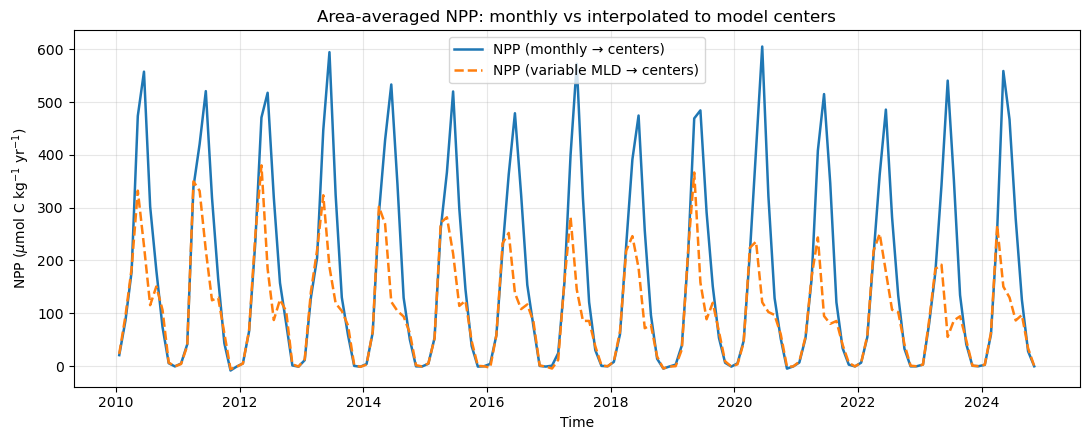

In [27]:
# --- Plot NPP over time: model-step vs monthly weighted mean ---
plt.figure(figsize=(11, 4.5))

# 1) NPP interpolated to model-step centers
plt.plot(
    centers,
    NPP_for_step,
    lw=1.8,
    label=r"NPP (monthly → centers)",
)

# 2) NPP integrated over variable MLD
plt.plot(
    centers,
    NPP_for_step_mld,
    lw=1.8,
    linestyle="--",
    color="tab:orange",
    label=r"NPP (variable MLD → centers)",
)

plt.title("Area-averaged NPP: monthly vs interpolated to model centers")
plt.xlabel("Time")
plt.ylabel(r"NPP ($\mu$mol C kg$^{-1}$ yr$^{-1}$)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "NPP_step_static_variable.png", dpi=300)
plt.show()


## EF- Ratio and NCP
Law et. al 2011

In [28]:
# --- SST (thetao at surface) for step centers ---------------------------------
SST_file = Path("../data/interim/") / "SST_for_step.npy"
sst_nc   = Path(SSTDir) / "cmems_nws_phy_sst.nc"

if SST_file.exists():
    print(f"Loading cached SST_for_step from {SST_file}")
    SST_for_step = np.load(SST_file)
    print(f"Loaded {len(SST_for_step)} steps.")
else:
    print("No cached SST_for_step found → preparing SST …")

    # Ensure we have the raw CMEMS subset NetCDF
    if not sst_nc.exists():
        print(f"No local SST NetCDF → downloading subset to {sst_nc}")
        copernicusmarine.subset(
            dataset_id="cmems_mod_nws_phy-t_my_7km-3D_P1M-m",   # NWS physics, monthly, 3D
            variables=["thetao"],                                 # potential temperature (°C)
            minimum_longitude=lon_min, maximum_longitude=lon_max,
            minimum_latitude=lat_min,  maximum_latitude=lat_max,
            start_datetime=start_time, end_datetime=end_time,     # monthly timestamps (clip if warned)
            minimum_depth=0, maximum_depth=0,                     # surface layer only
            output_filename="cmems_nws_phy_sst.nc",
            output_directory=SSTDir
        )
    else:
        print(f"Found local SST NetCDF: {sst_nc}")

    # Open and process to monthly regional mean (°C)
    ds_sst = xr.open_dataset(SSTDir + "cmems_nws_phy_sst.nc")

    # Handle depth dimension
    sst_var = ds_sst["thetao"]
    if "depth" in sst_var.dims:
        sst_var = sst_var.sel(depth=0)

    # Spatial average over region
    sst_mean = sst_var.mean(dim=['latitude','longitude'], skipna=True)

    # Make time tz-naive and interpolate to your model step centers
    sst_mean = sst_mean.assign_coords(
        time=pd.DatetimeIndex(sst_mean["time"].values).tz_localize(None)
    )
    SST_step = sst_mean.interp(time=centers)

    # Materialize and cache
    SST_for_step = SST_step.to_numpy()   # °C
    assert len(SST_for_step) == len(times) - 1, (len(SST_for_step), len(times)-1)

    np.save(SST_file, SST_for_step)  # °C
    print(f"Saved SST_for_step ({len(SST_for_step)} values) to {SST_file}")


Loading cached SST_for_step from ..\data\interim\SST_for_step.npy
Loaded 150 steps.


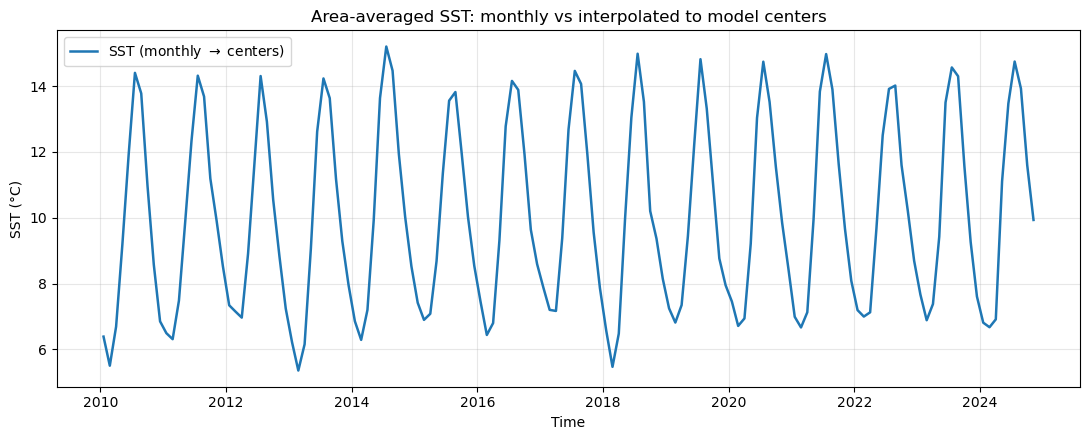

In [29]:
# --- Plot SST over time: model-step vs native monthly -------------------------
plt.figure(figsize=(11, 4.5))

# 1) SST interpolated to model-step centers (°C)
plt.plot(
    centers,
    SST_for_step,
    lw=1.8,
    label=r"SST (monthly $\rightarrow$ centers)",
)

plt.title("Area-averaged SST: monthly vs interpolated to model centers")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "SST_step.png", dpi=300)
plt.show()


### Option A

In [30]:
# --- EF- Ratio and NCP ---

# NPP_for_step: array in mg C m^-2 d^-1 
# SST_for_step: array in °C (same timeline, interpolated to your step centers)

# clip tiny negatives to zero
NPP = np.clip(NPP_for_step, 0.0, None)   # set negatives to 0

# Laws (2011) Eq. 3:
ef = (0.78 - 0.43 * (SST_for_step / 30.0)) * (0.04756 * (NPP ** 0.307))


# NCP (mg C m^-2 d^-1)
NCP_for_step = NPP * ef


# unit conversion to µmol C kg⁻¹ yr⁻¹:
rho = 1025.0  # kg m^-3
# mg m^-2 d^-1 → µmol m^-2 d^-1 (×1000/12)
# → µmol kg^-1 d^-1 by dividing by (rho*h1)
# → µmol kg^-1 yr^-1 by × DAYS_PER_YEAR
NCP_uM_kg_yr = NCP_for_step * (1000.0 / 12.0) / (rho * params['h1']) * DAYS_PER_YEAR # µmol C kg^-1 yr^-1

### Option B

In [31]:
# --- EF- Ratio and NCP ---

# clip tiny negatives to zero
NPP_mld = np.clip(NPP_for_step_mld, 0.0, None)   # set negatives to 0

# Laws (2011) Eq. 3:
ef_mld = (0.78 - 0.43 * (SST_for_step / 30.0)) * (0.04756 * (NPP_mld ** 0.307))


# NCP (mg C m^-2 d^-1)
NCP_for_step_mld = NPP_mld * ef_mld


# unit conversion to µmol C kg⁻¹ yr⁻¹:
rho = 1025.0  # kg m^-3
# mg m^-2 d^-1 → µmol m^-2 d^-1 (×1000/12)
# → µmol kg^-1 d^-1 by dividing by (rho*h1)
# → µmol kg^-1 yr^-1 by × DAYS_PER_YEAR
NCP_uM_kg_yr_mld = NCP_for_step_mld * (1000.0 / 12.0) / (rho * h1_for_step) * DAYS_PER_YEAR # µmol C kg^-1 yr^-1

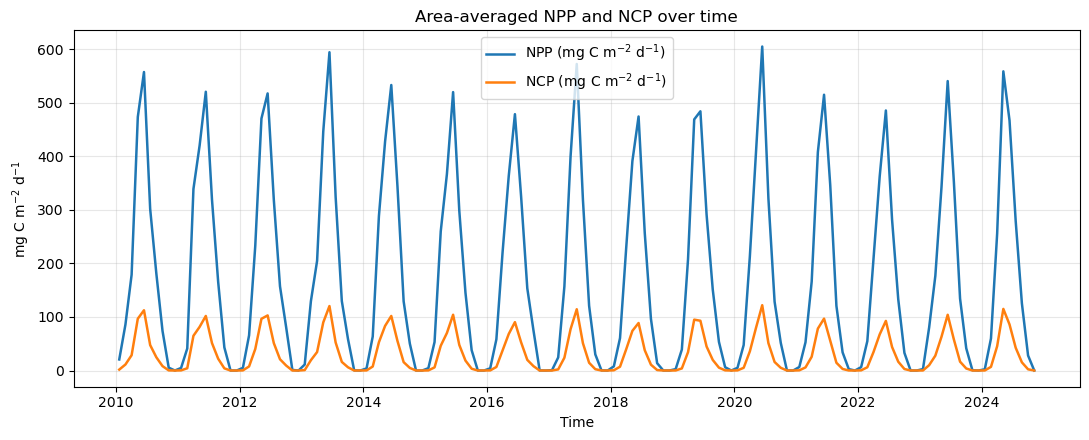

In [32]:
# µmol in mmol

# plot NPP and NCP_for_step
plt.figure(figsize=(11, 4.5))
plt.plot(
    centers,
    NPP,
    lw=1.8,
    label=r"NPP (mg C m$^{-2}$ d$^{-1}$)",
)
plt.plot(
    centers,
    NCP_for_step,
    lw=1.8,
    label=r"NCP (mg C m$^{-2}$ d$^{-1}$)",
)
plt.title("Area-averaged NPP and NCP over time")
plt.xlabel("Time")
plt.ylabel("mg C m$^{-2}$ d$^{-1}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "NPP_NCP_step.png", dpi=300)
plt.show()

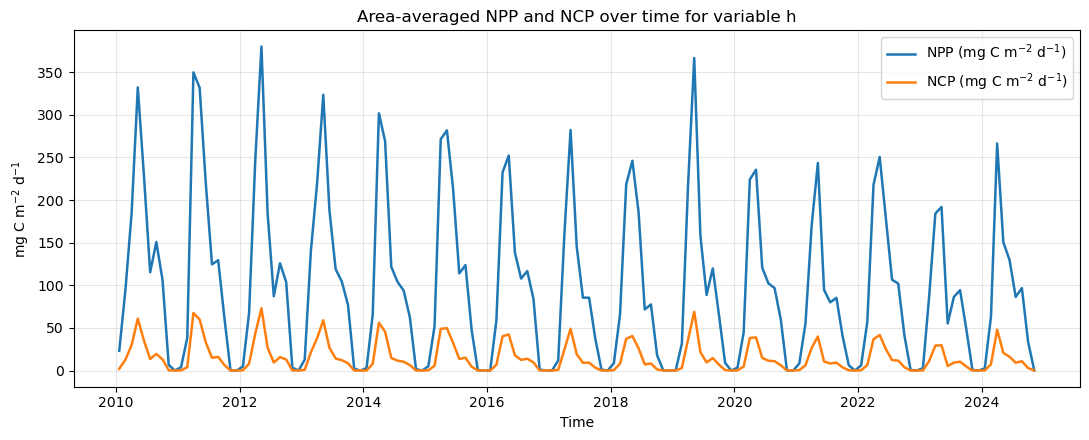

In [33]:
# µmol in mmol

# plot NPP and NCP_for_step
plt.figure(figsize=(11, 4.5))
plt.plot(
    centers,
    NPP_mld,
    lw=1.8,
    label=r"NPP (mg C m$^{-2}$ d$^{-1}$)",
)
plt.plot(
    centers,
    NCP_for_step_mld,
    lw=1.8,
    label=r"NCP (mg C m$^{-2}$ d$^{-1}$)",
)
plt.title("Area-averaged NPP and NCP over time for variable h")
plt.xlabel("Time")
plt.ylabel("mg C m$^{-2}$ d$^{-1}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "NPP_NCP_step_variable.png", dpi=300)
plt.show()

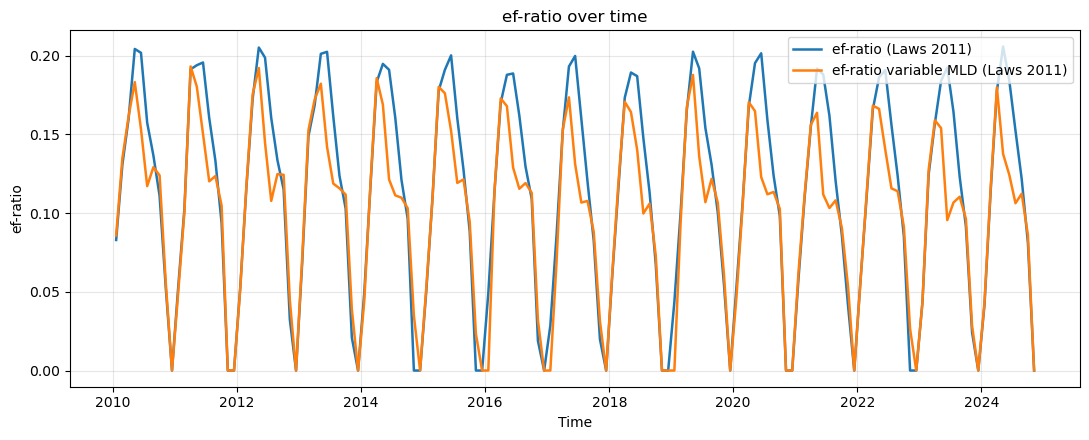

In [34]:
# plot ef
plt.figure(figsize=(11, 4.5))
plt.plot(
    centers,
    ef,
    lw=1.8,
    label=r"ef-ratio (Laws 2011)",
)

plt.plot(
    centers,
    ef_mld,
    lw=1.8,
    label=r"ef-ratio variable MLD (Laws 2011)",
)

plt.title("ef-ratio over time")
plt.xlabel("Time")
plt.ylabel("ef-ratio")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "ef_ratio_step_static_variable.png", dpi=300)
plt.show()

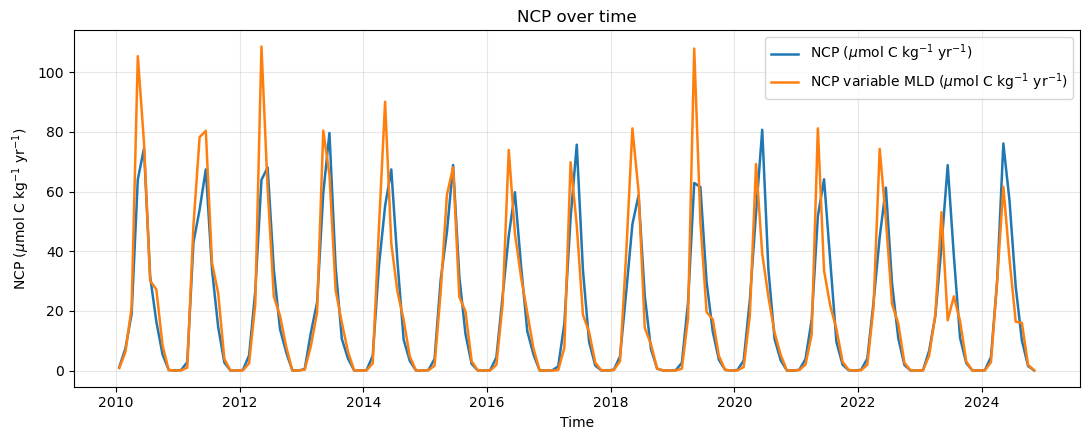

In [36]:
# plot NCP_uM_kg_yr
plt.figure(figsize=(11, 4.5))
plt.plot(
    centers,
    NCP_uM_kg_yr,
    lw=1.8,
    label=r"NCP ($\mu$mol C kg$^{-1}$ yr$^{-1}$)",
)

plt.plot(
    centers,
    NCP_uM_kg_yr_mld,
    lw=1.8,
    label=r"NCP variable MLD ($\mu$mol C kg$^{-1}$ yr$^{-1}$)",
)

plt.title("NCP over time")
plt.xlabel("Time")
plt.ylabel("NCP ($\mu$mol C kg$^{-1}$ yr$^{-1}$)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "NCP_step_variable.png", dpi=300)
plt.show()

# Biogeochemical Model

In [ ]:
# --- Initialize output ---
state = initial_state.copy()
states = [state.copy()]
pH_values = []
pCO2_surf_values = []
J_air_values = []
PIC_burial_values = []
POC_burial_values = []

shock_time = 2.0  # year when the alkalinity shock occurs
SHOCK_ADDED = False  # False = No shock added
                     # True  = Shock added
ENABLE_CONVECTION = False  # False = disable density-driven mixing
                           # True  = enable density-driven mixing
USE_VARIABLE_H = False  # False = Option A (fixed h1,h2 from params)
                       # True  = Option B (time-varying h1_for_step, h2_for_step)

# --- Euler Integration Loop ---
for i, t in enumerate(times[1:], start=1):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state # units °C, psu, µmol/kg, µmol/kg
    p = params

    # Apply alkalinity shock once
    if SHOCK_ADDED and abs(t - shock_time) < 1e-6:  # very small tolerance for float comparison
        TA1 += 1000.0  # µmol/kg
        SHOCK_ADDED = False

    # Seasonal Forcing Terms
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t + p['phi_1T']) # °C
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t + p['phi_2T']) # °C
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t + p['phi_1S']) # psu

    # Derivatives
    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T'] # °C/yr
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2'] # °C/yr
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S'] # psu/yr
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    # Calculate pCO2surf using PyCO2SYS
    co2sys_result = pyco2.sys(
    par1=TA1,
    par2=DIC1,
    par1_type=1,  # 1 = TA 
    par2_type=2,  # 2 = DIC
    salinity=S1,
    temperature=T1,
    pressure=0,  # sea surface pressure, in dbar

    total_silicate=0.0,     # explicitly zero
    total_phosphate=0.0,    # explicitly zero

    opt_k_carbonic=4,       # 4 = Mehrbach refit by Dickson & Millero (2007)
    opt_k_bisulfate=1,      # 1 = Dickson (1990)
    )

    pCO2_surf = co2sys_result['pCO2'] # µatm
    pCO2_surf_values.append(pCO2_surf)

    pH = co2sys_result['pH'] 
    pH_values.append(pH)

    # ------------------- Air-Sea CO2 Flux Calculation -------------------
    # wind forcing: O(1) array lookup now
    U2_now = U2_for_step[i-1]  # m^2 s^-2 for this model step

    # -- Compute k (cm/hr -> m/s) --
    k_cm_hr = float(k_W14_from_U2(U2_now, T1))                      # cm hr^-1 (in-situ)
    k_m_yr = k_cm_hr * (0.01 * 24.0 * DAYS_PER_YEAR)                # m yr^-1 (in-situ)

    # -- CO2 solubility K0 (Weiss 1974) --
    K0_mol_kg_atm = K0_weiss74_CO2(T1, S1)                          # mol kg^-1 atm^-1

    # --- geometry for this step ---
    if USE_VARIABLE_H:
    # ------------------- OPTION B ---------------------------------------------------
        h1_now = h1_for_step[i-1]
        h2_now = h2_for_step[i-1]
        delta_z_now = delta_z_for_step[i-1]

        # -- Bulk air-sea CO2 flux F = k * K0 * Δp -- 
        delta_p_atm = (pCO2_atm - pCO2_surf) * 1e-6                     # atm
        J_air = (k_m_yr * K0_mol_kg_atm * delta_p_atm) / h1_now * 1e6  # µmol kg^-1 yr^-1                        
        J_air_values.append(J_air)


        # --- mixing (per mass) ---
        mix_DIC1 =  KD_m2_yr * ((DIC2 - DIC1) / delta_z_now) / h1_now
        mix_DIC2 = -KD_m2_yr * ((DIC2 - DIC1) / delta_z_now) / h2_now
        mix_TA1  =  KD_m2_yr * ((TA2  - TA1 ) / delta_z_now) / h1_now
        mix_TA2  = -KD_m2_yr * ((TA2  - TA1 ) / delta_z_now) / h2_now


        # --- biology (per mass) ---
        NCP_mld = NCP_uM_kg_yr_mld[i-1]  
        bio_DIC1 = -(NCP_mld +              NCP_mld * p['PICPOC'])
        bio_DIC2 =  (NCP_mld * p['f_remin_POC'] + NCP_mld * p['PICPOC'] * p['f_remin_POC'])
        bio_TA1  = -2.0 * NCP_mld * p['PICPOC']
        bio_TA2  = +2.0 * NCP_mld * p['PICPOC'] * p['f_remin_POC']

        POC_burial = NCP_mld * (1.0 - p['f_remin_POC'])
        POC_burial_values.append(POC_burial)
        PIC_burial = NCP_mld * p['PICPOC'] * (1.0 - p['f_diss_PIC'])
        PIC_burial_values.append(PIC_burial)

    else:
        # ------------------- OPTION A ---------------------------------------------------
        # -- Bulk air-sea CO2 flux F = k * K0 * Δp -- 
        delta_p_atm = (pCO2_atm - pCO2_surf) * 1e-6                     # atm
        J_air = (k_m_yr * K0_mol_kg_atm * delta_p_atm) / p['h1'] * 1e6  # µmol kg^-1 yr^-1                        
        J_air_values.append(J_air)


        # --- mixing (per mass) ---
        mix_DIC1 =  KD_m2_yr * ((DIC2 - DIC1) / delta_z) / p['h1']
        mix_DIC2 = -KD_m2_yr * ((DIC2 - DIC1) / delta_z) / p['h2']
        mix_TA1  =  KD_m2_yr * ((TA2  - TA1 ) / delta_z) / p['h1']
        mix_TA2  = -KD_m2_yr * ((TA2  - TA1 ) / delta_z) / p['h2']


        # --- biology (per mass) ---
        NCP = NCP_uM_kg_yr[i-1]  
        bio_DIC1 = -(NCP +                 # organic C fixed
                     NCP * p['PICPOC'])    # inorganic C fixed as CaCO3
        
        bio_DIC2 =  (NCP * p['f_remin_POC'] +               # POC remin → DIC
                     NCP * p['PICPOC'] * p['f_diss_PIC'])  # PIC dissolution → DIC
        bio_TA1  = -2.0 * NCP * p['PICPOC']              # each mole CaCO3 formation lowers TA by 2
        bio_TA2  = +2.0 * NCP * p['PICPOC'] * p['f_diss_PIC'] # CaCO3 dissolution returns 2 TA

        POC_burial = NCP * (1.0 - p['f_remin_POC'])
        POC_burial_values.append(POC_burial)
        PIC_burial = NCP * p['PICPOC'] * (1.0 - p['f_diss_PIC'])
        PIC_burial_values.append(PIC_burial)

    # -------------------------------------------------------------------------------------
    # final tendencies (all in µmol kg^-1 yr^-1)
    dDIC1 = J_air + mix_DIC1 + bio_DIC1
    dDIC2 =         mix_DIC2 + bio_DIC2
    dTA1  =         mix_TA1  + bio_TA1
    dTA2  =         mix_TA2  + bio_TA2

    # Tentative Euler Step
    T1_hat = T1 + dt * dT1 # °C
    T2_hat = T2 + dt * dT2 # °C
    S1_hat = S1 + dt * dS1 # psu
    S2_hat = S2 + dt * dS2 # psu
    DIC1_hat = DIC1 + dt * dDIC1 # µmol/kg
    DIC2_hat = DIC2 + dt * dDIC2 # µmol/kg
    TA1_hat = TA1 + dt * dTA1   # µmol/kg
    TA2_hat = TA2 + dt * dTA2  # µmol/kg

    if USE_VARIABLE_H:
            if ENABLE_CONVECTION:
                # Pressures at representative depths (surface box near 0; deep at its mid-depth)
                p1 = 0.0
                p2 = h1_now + 0.5 * h2_now # meters ~ dbar

                #If sig1 > sig2: surface water is denser → convection occurs.
                #Else surface water is lighter → no convection.
                # Compute potential densities using TEOS-10
                sig1 = sigma0_from_TS(S1_hat, T1_hat, p1)
                sig2 = sigma0_from_TS(S2_hat, T2_hat, p2)

                # If surface water is denser → convective overturning
                if sig1 > sig2 - 1e-6:  # small tolerance to avoid numerical issues
                    mix_T = (h1_now * T1_hat + h2_now * T2_hat) / (h1_now + h2_now) # °C
                    mix_S = (h1_now * S1_hat + h2_now * S2_hat) / (h1_now + h2_now) # psu
                    mix_DIC = (h1_now * DIC1_hat + h2_now * DIC2_hat) / (h1_now + h2_now) # µmol/kg
                    mix_TA = (h1_now * TA1_hat + h2_now * TA2_hat) / (h1_now + h2_now)  # µmol/kg
                    state = np.array([mix_T, mix_T, mix_S, mix_S, mix_DIC, mix_DIC, mix_TA, mix_TA])
                else:
                    state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])
            else:
                # convection disabled → always take predicted values
                state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])

            states.append(state.copy())
    else:
        # --- Potential Density Mixing Condition ---
        if ENABLE_CONVECTION:
            # Pressures at representative depths (surface box near 0; deep at its mid-depth)
            p1 = 0.0
            p2 = p['h1'] + 0.5 * p['h2']  # meters ~ dbar

            #If sig1 > sig2: surface water is denser → convection occurs.
            #Else surface water is lighter → no convection.
            # Compute potential densities using TEOS-10
            sig1 = sigma0_from_TS(S1_hat, T1_hat, p1)
            sig2 = sigma0_from_TS(S2_hat, T2_hat, p2)

            # If surface water is denser → convective overturning
            if sig1 > sig2 - 1e-6:  # small tolerance to avoid numerical issues
                mix_T = (p['h1'] * T1_hat + p['h2'] * T2_hat) / (p['h1'] + p['h2']) # °C
                mix_S = (p['h1'] * S1_hat + p['h2'] * S2_hat) / (p['h1'] + p['h2']) # psu
                mix_DIC = (p['h1'] * DIC1_hat + p['h2'] * DIC2_hat) / (p['h1'] + p['h2']) # µmol/kg
                mix_TA = (p['h1'] * TA1_hat + p['h2'] * TA2_hat) / (p['h1'] + p['h2'])  # µmol/kg
                state = np.array([mix_T, mix_T, mix_S, mix_S, mix_DIC, mix_DIC, mix_TA, mix_TA])
            else:
                state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])
        else:
            # convection disabled → always take predicted values
            state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])

        states.append(state.copy())

# --- Save Results ---
columns = ['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2']
df = pd.DataFrame(states, columns=columns)
df['time'] = times

# Add a starting dummy value to match length
pH_values.insert(0, np.nan)
pCO2_surf_values.insert(0, np.nan)
J_air_values.insert(0, np.nan)
PIC_burial_values.insert(0, np.nan)
POC_burial_values.insert(0, np.nan)


# Add to dataframe
df['pH'] = pH_values
df['pCO2_surf'] = pCO2_surf_values
df['J_air'] = J_air_values
df['PIC_burial'] = PIC_burial_values
df['POC_burial'] = POC_burial_values

# Save to CSV
df.to_csv(processedDir + "GB_model_output.csv", index=False)

## Trajectories

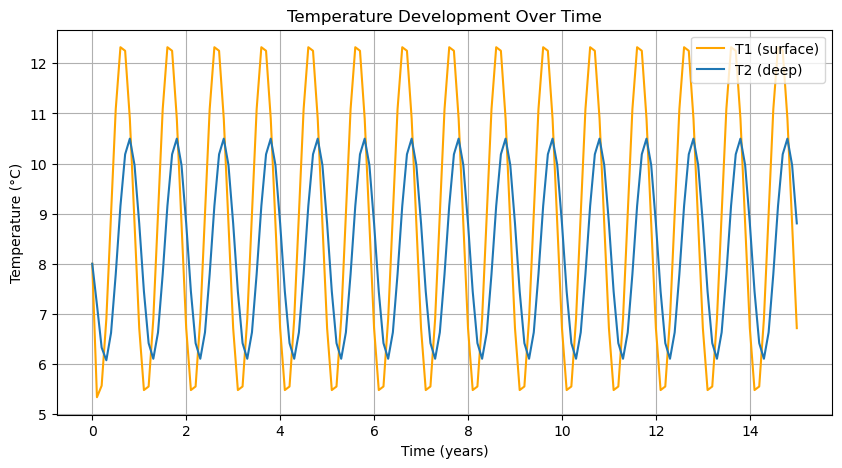

In [46]:
# --- Plotting: Temperature ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['T1'], label='T1 (surface)', color='orange')
plt.plot(df['time'], df['T2'], label='T2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "M_T1_T2.png", dpi=300)
plt.show()

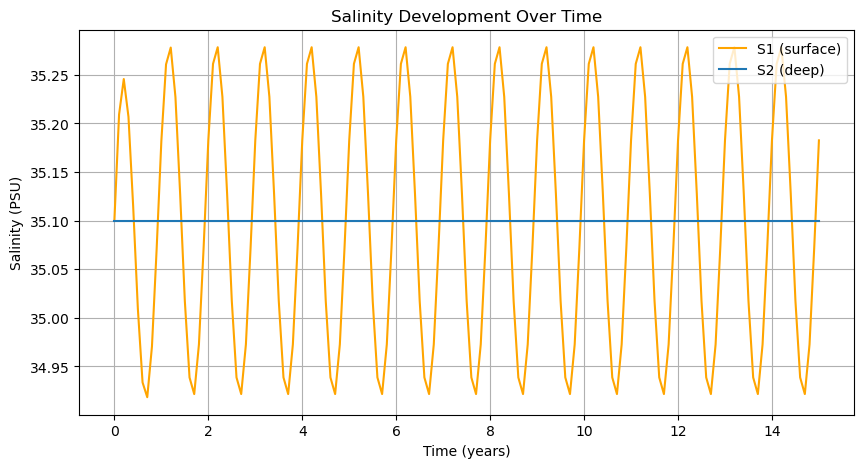

In [47]:
# --- Plotting: Salinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['S1'], label='S1 (surface)', color='orange')
plt.plot(df['time'], df['S2'], label='S2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Salinity (PSU)')
plt.title('Salinity Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "M_S1_S2.png", dpi=300)
plt.show()

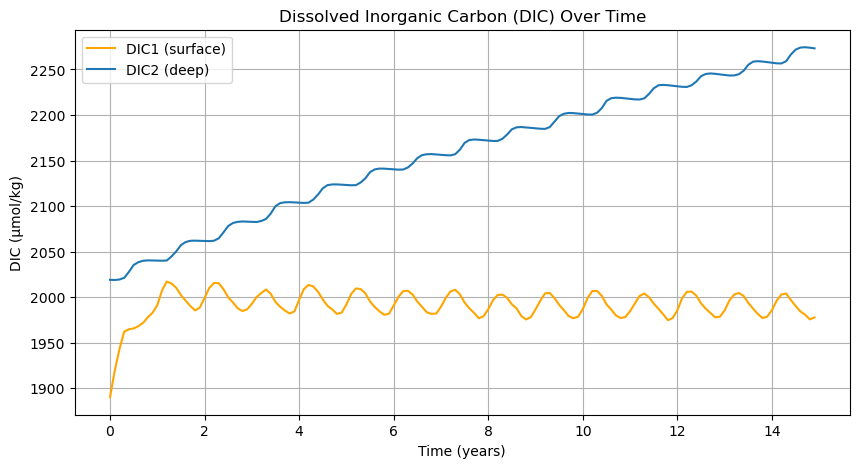

In [48]:
# --- Plotting: Disolved Inorganic Carbon ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['DIC1'], label='DIC1 (surface)', color='orange')
plt.plot(df['time'], df['DIC2'], label='DIC2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('DIC (µmol/kg)')
plt.title('Dissolved Inorganic Carbon (DIC) Over Time')
plt.legend()
plt.grid(True)
# Disable offset/scientific notation
plt.gca().yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.savefig(imgDir + "M_DIC1_DIC2.png", dpi=300)
plt.show()


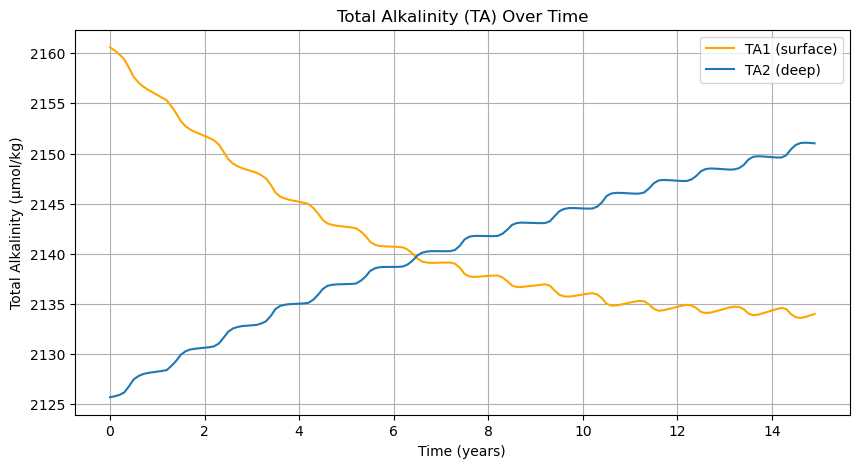

In [49]:
# --- Plotting: Alkalinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['TA1'], label='TA1 (surface)', color='orange')
plt.plot(df['time'], df['TA2'], label='TA2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Total Alkalinity (µmol/kg)')
plt.title('Total Alkalinity (TA) Over Time')
# Disable offset/scientific notation
plt.gca().yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "M_T1_T2.png", dpi=300)
plt.show()


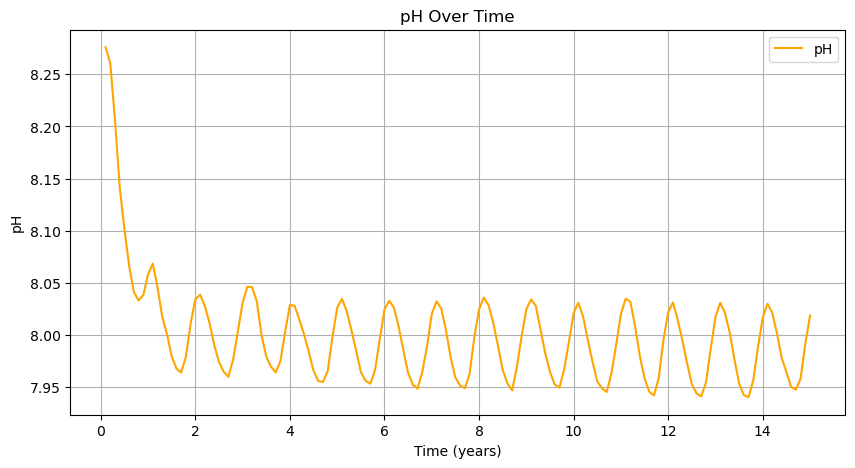

In [50]:
# --- Plotting: pH ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['pH'], label='pH', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('pH')
plt.title('pH Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "M_pH.png", dpi=300)
plt.show()

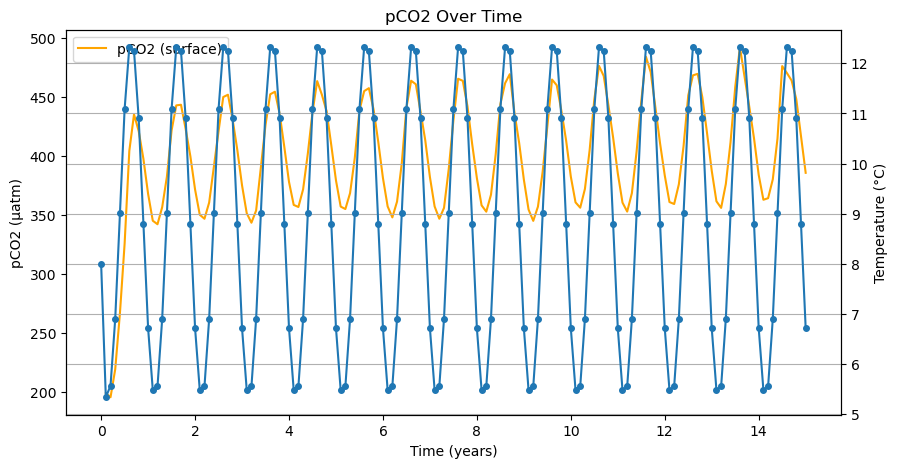

In [ ]:
# --- Plotting: pCO2 ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['pCO2_surf'], label='pCO2 (surface)', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('pCO2 (µatm)')
plt.title('pCO2 Over Time')
plt.legend()
# second axis for temperature
ax2 = plt.gca().twinx()
ax2.set_ylabel('Temperature (°C)')
ax2.tick_params(axis='y')
plt.plot(df['time'], df['T1'], linestyle='-', marker='o', markersize=4)
plt.grid(True)
plt.savefig(imgDir + "M_pCO2_T1.png", dpi=300)
plt.show()

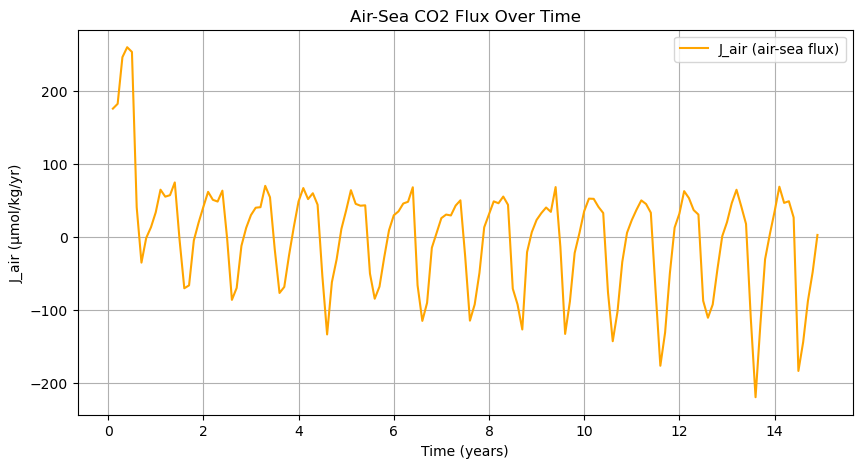

In [ ]:
# --- Plotting: J_air ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['J_air'], label='J_air (air-sea flux)', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('J_air (µmol/kg/yr)')
plt.title('Air-Sea CO2 Flux Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "M_J_air.png", dpi=300)
plt.show()

## Timing

In [ ]:
# Anchor on your sim_start and use your DAYS_PER_YEAR
sim_start_naive = (pd.Timestamp(sim_start).tz_convert("UTC").tz_localize(None)
                   if pd.Timestamp(sim_start).tz is not None
                   else pd.Timestamp(sim_start))

# Exact datetime for each model step
df["date_exact"] = sim_start_naive + pd.to_timedelta(df["time"] * DAYS_PER_YEAR, unit="D")

# Month-start timestamps (start of month)
df["date_month_start"] = df["date_exact"].dt.to_period("M").dt.to_timestamp(how="start")


print(df.head())


# Measurement Data: Comparison

## Ytre Utsira Station

In [ ]:
# --- Create a map ---
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([0, 7, 58, 63])  # wider map view around area


# --- Add rectangle for your lat/lon range ---
rect = Rectangle(
    (lon_min, lat_min),             # lower-left corner
    lon_max - lon_min,              # width (in degrees)
    lat_max - lat_min,              # height (in degrees)
    linewidth=2,
    edgecolor='blue',
    facecolor='blue',
    alpha=0.5,  # semi-transparent
    transform=ccrs.PlateCarree()
)

# --- Add port as dot and label ---
ax.plot(kollsnes_lon, kollsnes_lat, 'ro', markersize=5, transform=ccrs.PlateCarree(), label='Kollsnes Port')
ax.text(kollsnes_lon-1 , kollsnes_lat + 0.1, 'Kollsnes', transform=ccrs.PlateCarree(), size=14)
# Add data as dot and label
ax.plot(data_lon, data_lat, 'go', markersize=5, transform=ccrs.PlateCarree(), label='Ytre Utsira')
ax.text(data_lon - 1.2, data_lat + 0.1, 'Ytre Utsira', transform=ccrs.PlateCarree(), size=14)

ax.add_patch(rect)
ax.gridlines(draw_labels=True)
plt.show()


In [ ]:
# (English) column names
#names = [
#    "Station", "Month", "Year","Depth_m", "Temperature_C",
#    "Salinity", "Calibrated_Temperature_C", "Calibrated_Salinity"
#]

# Read as fixed-width, skip the original header line, and apply your names
#df = pd.read_fwf(rawDir + "stasjonsdata.txt", header=None, names=names, skiprows=1)

# --- robust Month -> month number (supports Eng + Norwegian) ---
#month_map = {
#    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
#    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
#}
#m_raw = df["Month"].astype(str).str.strip().str.lower().str[:3]
#m_num = m_raw.map(month_map)


# --- numeric year ---
#y_num = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

# --- build Date as first of month (no string concat) ---
#df["Date"] = pd.to_datetime(
#    {"year": y_num, "month": m_num, "day": 1},
#    errors="coerce"
#)

# Drop the original Month/Year and (optionally) reorder columns
#df = df.drop(columns=["Month", "Year"])
#cols = ["Station","Date","Depth_m","Temperature_C","Salinity","Calibrated_Temperature_C","Calibrated_Salinity"]
#df = df[[c for c in cols if c in df.columns]]  # only those that exist


# Coerce numeric columns
#for c in ["Depth_m", "Temperature_C", "Salinity",
#          "Calibrated_Temperature_C", "Calibrated_Salinity"]:
#    df[c] = pd.to_numeric(df[c], errors="coerce")


# Save
#df.to_csv(interimDir +"stasjonsdata.csv", index=False, encoding="utf-8")
#print(f"Saved {len(df)} rows to {interimDir +'stasjonsdata.csv'}")

In [ ]:
# Read the processed station data
df_utsira = pd.read_csv(interimDir + "stasjonsdata.csv")
print(df_utsira.head())

In [ ]:
df = df_utsira.copy()

# make sure Date is datetime and data are sorted
if pd.api.types.is_numeric_dtype(df["Date"]):
    df["Date"] = pd.to_datetime(df["Date"].astype("Int64").astype(str).str.zfill(8),
                                format="%Y%m%d", errors="coerce")
else:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df_30 = (df.loc[df["Depth_m"] == 30, ["Date","Temperature_C", "Salinity"]]
           .dropna()
           .sort_values("Date"))

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_30["Date"], df_30["Temperature_C"], alpha=0.7, label="30 m Depth", s=20)
# add a line
ax.plot(df_30["Date"], df_30["Temperature_C"], alpha=0.5, color="gray", lw=1)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Temperature at 30 m Depth Over Time (Ytre Utsira)")
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

# make dates readable without mdates
fig.autofmt_xdate()                 # auto-rotate and align labels
ax.tick_params(axis="x", labelsize=8)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_30["Date"], df_30["Salinity"], alpha=0.7, label="30 m Depth", s=20)
# add a line
ax.plot(df_30["Date"], df_30["Salinity"], alpha=0.5, color="gray", lw=1)
ax.set_xlabel("Date")
ax.set_ylabel("Salinity (PSU)")
ax.set_title("Salinity at 30 m Depth Over Time (Ytre Utsira)")
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

# make dates readable without mdates
fig.autofmt_xdate()                 # auto-rotate and align labels
ax.tick_params(axis="x", labelsize=8)
plt.tight_layout()
plt.show()

## Ocean Weather Station Mike (Position: 66°N 2° E)

In [ ]:
# Data location
data_lat, data_lon = 66, 2 
# --- Create a map ---
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-10, 20, 40, 70])  # wider map view around area


# --- Add rectangle for your lat/lon range ---
rect = Rectangle(
    (lon_min, lat_min),             # lower-left corner
    lon_max - lon_min,              # width (in degrees)
    lat_max - lat_min,              # height (in degrees)
    linewidth=2,
    edgecolor='blue',
    facecolor='blue',
    alpha=0.5,  # semi-transparent
    transform=ccrs.PlateCarree()
)

# Add data as dot and label to the left of the dot
ax.plot(data_lon, data_lat, 'go', markersize=5, transform=ccrs.PlateCarree(), label='Mike Station')
ax.text(data_lon - 6, data_lat, 'Mike Station', transform=ccrs.PlateCarree())

ax.add_patch(rect)
ax.gridlines(draw_labels=True)
plt.show()


In [ ]:
# import mike data from csv
df_mike = pd.read_csv(interimDir + "mike_station.csv", sep=";")

In [ ]:
df = df_mike.copy()

# 1) Clean up obvious end row and missing dates
df = df[df["EXPOCODE"] != "END_DATA"]
df = df[~df["DATE"].isna()]

# 2) Build a proper datetime from DATE (YYYYMMDD) and TIME (HHMM or HHMMSS or 0)
# DATE arrives as float (e.g., 20011124.0) → make 8-char string
date_str = df["DATE"].astype("Int64").astype(str).str.zfill(8)

def to_time_str(x):
    if pd.isna(x):
        return "000000"
    x = int(x)
    s = f"{x:06d}"   # handles 0 -> '000000', 930 -> '000930', 123015 -> '123015'
    # if it's HHMM (length 4 after removing leading zeros), pad to HHMMSS
    # but since we zero-fill to 6 already, simply return s
    return s

time_str = df["TIME"].apply(to_time_str)

# Combine and parse
df["timestamp"] = pd.to_datetime(date_str + time_str, format="%Y%m%d%H%M%S", errors="coerce")

# 3) Clean the data you want to plot (drop fill values like -999)
alk_col = "ALKALI_umol_kg"
bad_vals = {-999, -999.0, -9999, -9}  # common flags; adjust if needed
df = df[(~df[alk_col].isna()) & (~df[alk_col].isin(bad_vals)) & (~df["timestamp"].isna())]

# 4) Sort by time (important for a sensible line plot)
df = df.sort_values("timestamp")


# 5) Plot
plt.figure(figsize=(10, 5))
# only dots
plt.plot(df["timestamp"], df[alk_col], label="Alkalinity (µmol/kg)", linestyle='None', marker='o', markersize=4)
plt.plot(df["timestamp"], df[alk_col], color='gray', alpha=0.5, lw=1)  # light line to connect dots
# from start_time
plt.xlim(sim_start_naive, df["timestamp"].max() + pd.Timedelta(days=30))
plt.xlabel("Date")
plt.ylabel("Alkalinity (µmol/kg)")
plt.title("Alkalinity at Mike Station Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(df.columns)

## SOCAT data

In [ ]:
# Open the dataset
socat_data = xr.open_dataset(rawDir + "SOCATv2024_tracks_gridded_monthly.nc")

# List all variables
print("Variables:\n", list(socat_data.data_vars))

In [ ]:
# keep your local tz-naive endpoints
sel_start = sim_start.tz_localize(None)
sel_end   = sim_end.tz_localize(None)

# numpy datetime64 endpoints (ns precision)
start64 = np.datetime64(sel_start, "ns")
end64   = np.datetime64(sel_end,   "ns")

# make a DataArray mask on the 'tmnth' coord
tm = socat_data["tmnth"]
cond = (tm >= start64) & (tm <= end64)   # this is a DataArray (good)

# spatial + temporal subset
socat_norway_data = socat_data[
    ["sst_ave_weighted", "salinity_ave_weighted", "fco2_ave_weighted"]
].sel(ylat=slice(lat_min, lat_max), xlon=slice(lon_min, lon_max)) \
 .where(cond, drop=True)

# area mean
socat_mean = socat_norway_data.mean(dim=["xlon","ylat"], skipna=True)

# sanity check
print(pd.to_datetime(socat_mean["tmnth"].values))

In [ ]:
# Convert area mean to pandas DataFrame
socat_mean_df = socat_mean.to_dataframe().reset_index()

# Rename for consistency
socat_mean_df = socat_mean_df.rename(columns={
    'tmnth': 'date_exact',
    'sst_ave_weighted': 'T1_obs',
    'salinity_ave_weighted': 'S1_obs',
    'fco2_ave_weighted': 'pCO2_obs'
})

socat_mean_df["date_month_start"] = socat_mean_df["date_exact"].dt.to_period("M").dt.to_timestamp(how="start")

print(socat_mean_df.head())

In [ ]:
# --- Plot helper function ---
def plot_time_series(df, var, label, ylabel):
    plt.figure(figsize=(12, 4))
    plt.plot(df["date_month_start"], df[var],
             label=label, linestyle='--', marker='o', markersize=4)
    plt.title(f"{label} (2013–2018) Norway")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(imgDir + f"{var}_time_series.png", dpi=300)
    plt.show()

# --- Plot each observed variable ---
plot_time_series(socat_mean_df, 'T1_obs', 'Sea Surface Temperature', '°C')
plot_time_series(socat_mean_df, 'S1_obs', 'Salinity', 'PSU')
plot_time_series(socat_mean_df, 'pCO2_obs', r'$fCO_2$', 'µatm')

In [ ]:
# --- Plot: Model vs SOCAT Surface Temperature ---
plt.figure(figsize=(10, 5))
plt.plot(socat_mean_df['date_month_start'], socat_mean_df['T1_obs'],
         label='SOCAT Area Mean Temperature', linestyle='--', marker='o', markersize=4)
plt.plot(df['date_month_start'], df['T1'], label='Model Temperature (surface)', color='orange')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Model vs SOCAT Area Mean Surface Temperature')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Temperature.png", dpi=300)
plt.show()

In [ ]:
# --- Plot: Model vs SOCAT Surface Salinity ---
plt.figure(figsize=(10, 5))
plt.plot(socat_mean_df['date_month_start'], socat_mean_df['S1_obs'],
         label='SOCAT Area Mean Salinity', linestyle='--', marker='o', markersize=4)
plt.plot(df['date_month_start'], df['S1'], label='Model Salinity (surface)', color='orange')
plt.xlabel('Year')
plt.ylabel('Salinity (PSU)')
plt.title('Model vs SOCAT Area Mean Surface Salinity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Salinity.png", dpi=300)
plt.show()

In [ ]:
# --- Plot: Model vs SOCAT Surface pCO₂ ---
plt.figure(figsize=(10, 5))
plt.plot(socat_mean_df['date_month_start'], socat_mean_df['pCO2_obs'],
         label='SOCAT Area Mean pCO₂', linestyle='--', marker='o', markersize=4)
plt.plot(df['date_month_start'], df['pCO2_surf'], label='Model pCO₂ (surface)', color='orange')
plt.xlabel('Year')
plt.ylabel('pCO₂ (µatm)')
plt.title('Model vs SOCAT Area Mean Surface pCO₂')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "GB_model_vs_SOCAT_pCO2.png", dpi=300)
plt.show()

## Glodap data

In [ ]:
df_glodap = pd.read_csv(rawDir + "GLODAPv2.2023_Merged_Master_File.csv", low_memory=False)


In [ ]:
# Basic structure
print(df_glodap.shape)             # Number of rows and columns
print(df_glodap.columns.tolist())  # List of column names

# set all -9999 to NaN
df_glodap.replace(-9999, np.nan, inplace=True)

In [ ]:
# 1) Make sure the key columns are numeric
for col in ['G2latitude','G2longitude','G2year','G2month','G2day','G2depth']:
    df_glodap[col] = pd.to_numeric(df_glodap[col], errors='coerce')

# 2) Quick stats (ignore NaNs)
lat_min_data  = np.nanmin(df_glodap['G2latitude'].values)
lat_max_data  = np.nanmax(df_glodap['G2latitude'].values)
lon_min_data  = np.nanmin(df_glodap['G2longitude'].values)
lon_max_data  = np.nanmax(df_glodap['G2longitude'].values)
year_min_data = np.nanmin(df_glodap['G2year'].values)
year_max_data = np.nanmax(df_glodap['G2year'].values)

print(df_glodap[['G2latitude','G2longitude','G2year']].dtypes)
print("Years in file:", int(year_min_data), "→", int(year_max_data))
print("Lon range in file:", lon_min_data, "→", lon_max_data)
print("Lat range in file:", lat_min_data, "→", lat_max_data)

# 3) See which filter is knocking things out
m_lat = df_glodap['G2latitude'].between(lat_min, lat_max)
m_lon = df_glodap['G2longitude'].between(lon_min, lon_max)
m_yr  = (df_glodap['G2year'] >= sim_start.year) & (df_glodap['G2year'] <= sim_end.year)

print("Rows total:", len(df_glodap))
print("Pass lat:", int(m_lat.sum()))
print("Pass lon:", int(m_lon.sum()))
print("Pass year:", int(m_yr.sum()))
print("Pass all:", int((m_lat & m_lon & m_yr).sum()))


In [ ]:
# Define your analysis years dynamically from the model run
year_min = sim_start.year
year_max = sim_end.year

print(f"Filtering GLODAP data for years {year_min}–{year_max}")
df_filtered = df_glodap[
    (df_glodap['G2latitude'].between(lat_min, lat_max)) &
    (df_glodap['G2longitude'].between(lon_min, lon_max)) &
    (df_glodap['G2year'] >= year_min) &
    (df_glodap['G2year'] <= year_max)
]

In [ ]:
# Surface and deep cutoffs 
surface_depth = params['h1']  
deep_depth = params['h2']  	

# --- Subset Surface and Deep Layers ---
df_surface = df_filtered[df_filtered['G2depth'] <= surface_depth].copy()
df_deep = df_filtered[
    (df_filtered['G2depth'] > surface_depth) &
    (df_filtered['G2depth'] <= deep_depth)
].copy()

# --- Select relevant variables ---
vars_of_interest = [
    'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute',
    'G2temperature', 'G2salinity', 'G2tco2',
    'G2talk', 'G2fco2', 'G2phts25p0'
]
df_surface = df_surface[vars_of_interest].copy()
df_deep = df_deep[vars_of_interest].copy()

# --- Combine year + month into proper datetime ---
df_surface['date_exact'] = pd.to_datetime(
    dict(year=df_surface['G2year'], month=df_surface['G2month'], day=df_surface['G2day'], hour=df_surface['G2hour'], minute=df_surface['G2minute'])
)
df_deep['date_exact'] = pd.to_datetime(
    dict(year=df_deep['G2year'], month=df_deep['G2month'], day=df_deep['G2day'], hour=df_deep['G2hour'], minute=df_deep['G2minute'])
)

# --- Create "month start" column for alignment ---
df_surface['date_month_start'] = df_surface['date_exact'].dt.to_period("M").dt.to_timestamp(how="start")
df_deep['date_month_start'] = df_deep['date_exact'].dt.to_period("M").dt.to_timestamp(how="start")

# --- Monthly means ---
df_surface_monthly = df_surface.groupby('date_month_start').mean(numeric_only=True).reset_index()
df_deep_monthly = df_deep.groupby('date_month_start').mean(numeric_only=True).reset_index()

# --- Select relevant output variables ---
vars_of_interest = [
    'date_month_start', 
    'G2temperature', 'G2salinity', 'G2tco2',
    'G2talk', 'G2fco2', 'G2phts25p0'
]
df_surface_monthly = df_surface_monthly[vars_of_interest].copy()
df_deep_monthly  = df_deep_monthly[vars_of_interest].copy()

# --- Rename for consistency with your model ---
df_surface_monthly = df_surface_monthly.rename(columns={
    'G2temperature': 'T1_obs',
    'G2salinity': 'S1_obs',
    'G2tco2': 'DIC1_obs',
    'G2talk': 'TA1_obs',
    'G2fco2': 'pCO2_obs',
    'G2phts25p0': 'pH_obs'
})

df_deep_monthly = df_deep_monthly.rename(columns={
    'G2temperature': 'T2_obs',
    'G2salinity': 'S2_obs',
    'G2tco2': 'DIC2_obs',
    'G2talk': 'TA2_obs',
    'G2fco2': 'pCO2_obs',
    'G2phts25p0': 'pH_obs'
})

print("Surface Data Sample:\n", df_surface_monthly.head())
print("Deep Data Sample:\n", df_deep_monthly.head())


In [ ]:
def plot_model_vs_glodap(model_df, obs_df, var_model, var_obs,
                         title=None):
    plt.figure(figsize=(12, 4))

    # Plot GLODAP observational data
    plt.plot(obs_df['date_month_start'], obs_df[var_obs], label=f'GLODAP: {var_obs}', linestyle='--', marker='o', markersize=4)

    # Plot model data
    plt.plot(model_df['date_month_start'], model_df[var_model], label=f'Model: {var_model}')

    # Title and labels
    plot_title = title
    plt.title(plot_title)
    plt.xlabel("Year")
    plt.ylabel(var_model.replace('_', ' '))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='T1',         # model variable name in df
    var_obs='T1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Temperature'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='S1',         # model variable name in df
    var_obs='S1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Salinity'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='DIC1',         # model variable name in df
    var_obs='DIC1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface DIC'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='TA1',         # model variable name in df
    var_obs='TA1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Alkalinity'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='pH',         # model variable name in df
    var_obs='pH_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface pH'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='pCO2_surf',         # model variable name in df
    var_obs='pCO2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface pCO2'
)

In [ ]:
plot_model_vs_glodap(
    model_df=df,
    obs_df=df_deep_monthly,
    var_model='T2',         # model variable name in df
    var_obs='T2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Temperature'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_deep_monthly,
    var_model='S2',         # model variable name in df
    var_obs='S2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Salinity'
)